# Triangular_fuzzy_number_generate_BPA

## Import library

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from scipy.stats import norm
import itertools
from collections import defaultdict
import matplotlib.pyplot as plt

In [2]:
# 1. 加载Iris数据集并划分为训练集和测试集
iris = load_iris()
X = iris.data  # 四个属性
y = iris.target  # 三个类 (0, 1, 2)
num_classes = len(np.unique(iris.target))
num_attributes = iris.data.shape[1]
# 将数据集划分为训练集和测试集，乱序
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

## Get mean and std

In [3]:
# 2. 计算每个类中每个属性的 mean value and standard deviation (无偏估计)

def calculate_mean_std_by_class(X_train, y_train, num_classes):
    mean_std_by_class = []
    for class_label in range(num_classes):
        X_class = X_train[y_train == class_label]
        mean_std = [(np.mean(X_class[:, i]), np.std(X_class[:, i], ddof=1)) for i in range(X_class.shape[1])]
        mean_std_by_class.append(mean_std)
    
    return np.array(mean_std_by_class)

def calculate_mean_std_min_max_by_class(X_train, y_train, num_classes):
    mean_std_by_class = []
    for class_label in range(num_classes):
        X_class = X_train[y_train == class_label]
        mean_std = [(np.mean(X_class[:, i]), np.std(X_class[:, i], ddof=1), np.min(X_class[:, i]), np.max(X_class[:, i])) for i in range(X_class.shape[1])]
        mean_std_by_class.append(mean_std)
    
    return np.array(mean_std_by_class)

mean_std_min_max_by_class = calculate_mean_std_min_max_by_class(X_train, y_train, num_classes)
print("每个类中每个属性的均值，标准差，最小值，最大值:\n", mean_std_min_max_by_class)
print("Shape of mean_std_by_class:\n", mean_std_min_max_by_class.shape)

每个类中每个属性的均值，标准差，最小值，最大值:
 [[[4.99       0.3564785  4.3        5.8       ]
  [3.4525     0.39547926 2.3        4.4       ]
  [1.45       0.18397324 1.         1.9       ]
  [0.245      0.10609623 0.1        0.6       ]]

 [[5.9195122  0.54231887 4.9        7.        ]
  [2.77073171 0.32034661 2.         3.4       ]
  [4.24146341 0.4811318  3.         5.1       ]
  [1.32195122 0.20556288 1.         1.8       ]]

 [[6.53333333 0.65386838 4.9        7.7       ]
  [2.96666667 0.31898963 2.2        3.8       ]
  [5.52051282 0.5415278  4.5        6.7       ]
  [2.         0.2901905  1.4        2.5       ]]]
Shape of mean_std_by_class:
 (3, 4, 4)


In [4]:
p = 0.4

In [5]:
def get_triangular_membership_functions(mean, std, min_val, max_val, p=0.4):

    u = max_val + p * std  
    l = min_val - p * std  

    def triangular_membership_function(x):
        if x < l:
            return 0  
        elif x > u:
            return 0  
        elif l <= x <= mean:
            return (x - l) / (mean - l)
        elif mean < x <= u:
            return (u - x) / (u - mean)
        else:
            return 0  
    return triangular_membership_function

In [6]:
def get_triangular_membership_functions_list(mean_std_by_class):
    triangular_membership_functions_by_class = []
    for class_data in mean_std_by_class:
        class_functions = []
        for attr_data in class_data:
            mean, std, min_val, max_val = attr_data
            membership_function = get_triangular_membership_functions(mean, std, min_val, max_val)
            class_functions.append(membership_function)
        triangular_membership_functions_by_class.append(class_functions)
    return np.array(triangular_membership_functions_by_class)

triangular_membership_functions_by_class = get_triangular_membership_functions_list(mean_std_min_max_by_class)
triangular_membership_functions_by_class.shape

(3, 4)

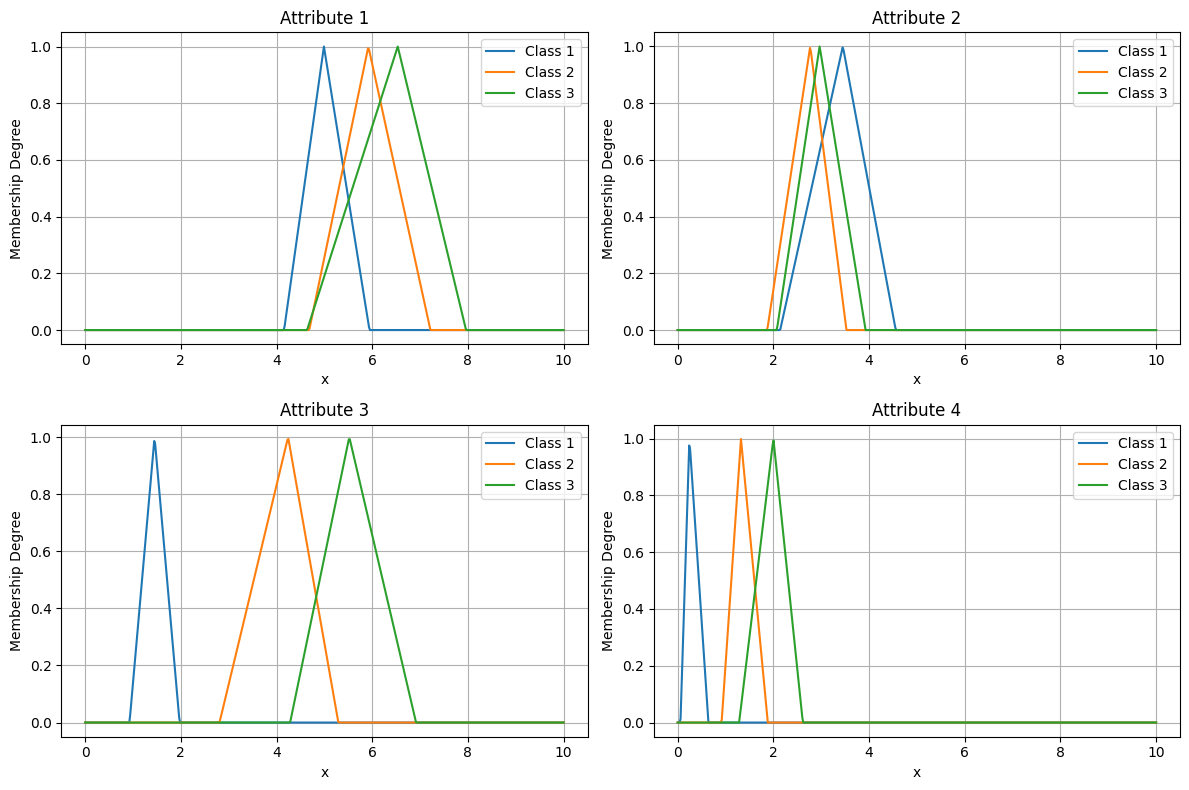

In [7]:
def plot_triangular_membership_functions(triangular_membership_functions_by_class):
    num_classes, num_attributes = triangular_membership_functions_by_class.shape
    
    # Generate x values for plotting
    x_values = np.linspace(0, 10, 500)  # Assuming a reasonable range for x (e.g., [0, 10])
    
    # Determine number of rows and columns for subplots
    num_rows = (num_attributes + 1) // 2  # Two plots per row
    num_cols = 2
    
    # Create subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 4 * num_rows))
    axes = axes.flatten()  # Flatten the axes array to make indexing easier
    
    # Plot membership functions for each attribute
    for attr_index in range(num_attributes):
        ax = axes[attr_index]
        for class_index in range(num_classes):
            # Get the triangular membership function for the given class and attribute
            membership_function = triangular_membership_functions_by_class[class_index][attr_index]
            # Calculate the y values by passing x values through the membership function
            y_values = [membership_function(x) for x in x_values]
            # Plot the curve for this class
            ax.plot(x_values, y_values, label=f'Class {class_index + 1}')
        
        # Add titles and labels
        ax.set_title(f'Attribute {attr_index + 1}')
        ax.set_xlabel('x')
        ax.set_ylabel('Membership Degree')
        ax.legend()
        ax.grid(True)
    
    # Remove any unused subplots
    if num_attributes % 2 != 0:
        fig.delaxes(axes[-1])

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

plot_triangular_membership_functions(triangular_membership_functions_by_class)

In [8]:
sample = np.random.randint(0, len(X_test))
test_sample = (X_test[sample], y_test[sample])
test_sample

(array([6.5, 3.2, 5.1, 2. ]), 2)

In [9]:

def calculate_membership_for_sample(test_sample, triangular_membership_functions_by_class):

    test_values, true_class = test_sample  # 获取属性值和真实类别
    num_classes = len(triangular_membership_functions_by_class)
    num_attributes = len(test_values)
    
    # 初始化一个存储隶属度值的列表
    membership_values = []
    
    for class_idx in range(num_classes):
        class_membership_values = []
        for attr_idx in range(num_attributes):
            # 获取对应类和属性的三角隶属函数
            membership_function = triangular_membership_functions_by_class[class_idx][attr_idx]
            # 计算该属性值的隶属度
            membership_value = membership_function(test_values[attr_idx])
            class_membership_values.append(membership_value)
        membership_values.append(class_membership_values)
    
    return np.array(membership_values)


# Calculate the membership values for the test sample
membership_values = calculate_membership_for_sample(test_sample, triangular_membership_functions_by_class)

membership_values  # This will output the membership values for each class and attribute


array([[0.        , 0.80735363, 0.        , 0.        ],
       [0.55258137, 0.43323956, 0.18311577, 0.        ],
       [0.98240874, 0.75717947, 0.66008837, 1.        ]])

In [10]:
def plot_triangular_membership_functions_with_sample(triangular_membership_functions_by_class, test_sample):
    test_values, true_class = test_sample  # 获取属性值和真实类别
    num_classes = len(triangular_membership_functions_by_class)
    num_attributes = len(test_values)
    
    # Generate x values for plotting
    x_values = np.linspace(0, 10, 500)  # 假设x的合理范围 (例如 [0, 10])
    
    # Determine number of rows and columns for subplots
    num_rows = (num_attributes + 1) // 2  # 两个图每行
    num_cols = 2
    
    # Create subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 4 * num_rows))
    axes = axes.flatten()  # Flatten the axes array to make indexing easier
    
    # Plot membership functions for each attribute
    for attr_index in range(num_attributes):
        ax = axes[attr_index]
        for class_index in range(num_classes):
            # Get the triangular membership function for the given class and attribute
            membership_function = triangular_membership_functions_by_class[class_index][attr_index]
            # Calculate the y values by passing x values through the membership function
            y_values = [membership_function(x) for x in x_values]
            # Plot the curve for this class
            ax.plot(x_values, y_values, label=f'Class {class_index + 1}')
        
        # 绘制测试样本的隶属度点
        for class_index in range(num_classes):
            membership_function = triangular_membership_functions_by_class[class_index][attr_index]
            test_value = test_values[attr_index]  # 获取测试样本的属性值
            test_membership_value = membership_function(test_value)  # 计算测试样本的隶属度
            # 在图上标记测试样本的隶属度值
            ax.plot(test_value, test_membership_value, 'ro')  # 红点表示测试样本值
            ax.text(test_value, test_membership_value, f'{test_membership_value:.2f}', fontsize=12, color='red')
        
        # Add titles and labels
        ax.set_title(f'Attribute {attr_index + 1}')
        ax.set_xlabel('x')
        ax.set_ylabel('Membership Degree')
        ax.legend()
        ax.grid(True)
    
    # Remove any unused subplots
    if num_attributes % 2 != 0:
        fig.delaxes(axes[-1])

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

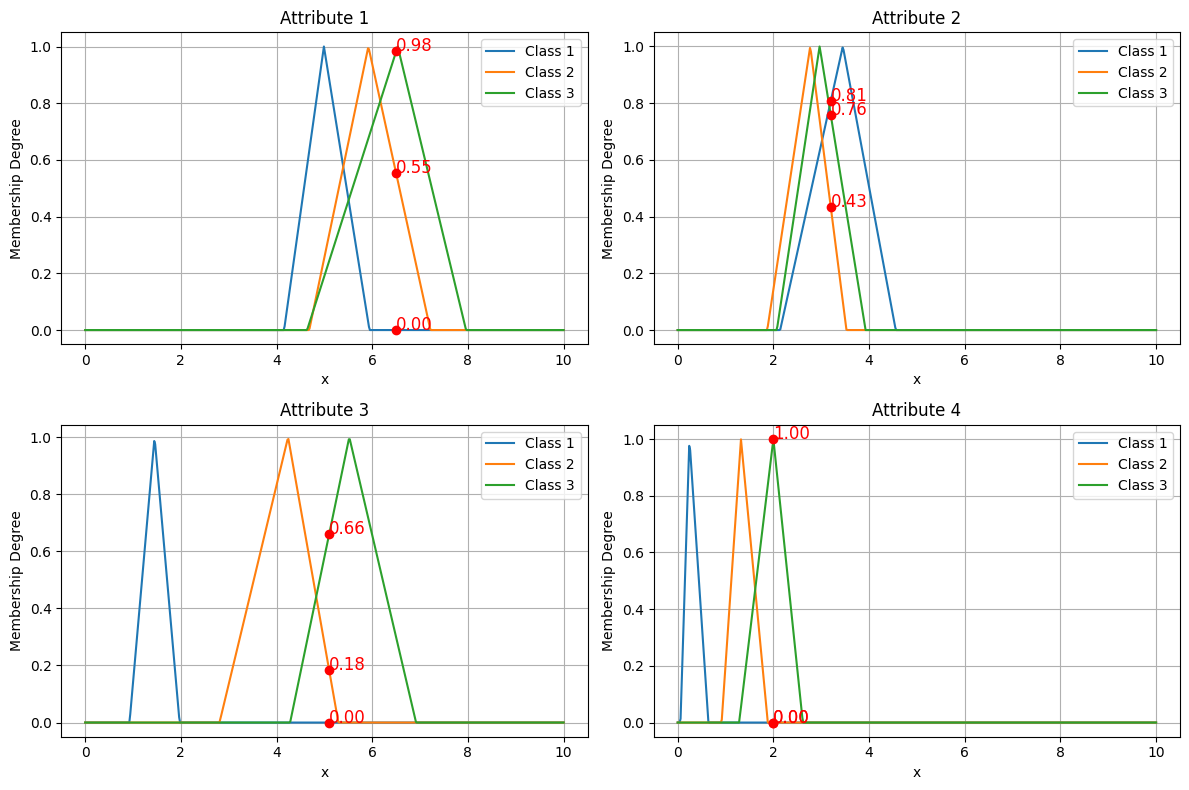

In [11]:
plot_triangular_membership_functions_with_sample(triangular_membership_functions_by_class, test_sample)

In [12]:
def sort_membership(membership_values):
    sorted_indices = np.argsort(-membership_values, axis=0)  # 降序排序，使用负号实现降序
    sorted_mv = np.take_along_axis(membership_values, sorted_indices, axis=0)  # 按照索引排序后的值
    return sorted_indices, sorted_mv

In [13]:
sorted_indices, sorted_mv = sort_membership(membership_values)

In [14]:
print("\nsorted_indices\n", sorted_indices)
print("\nsorted_mv\n", sorted_mv)


sorted_indices
 [[2 0 2 2]
 [1 2 1 0]
 [0 1 0 1]]

sorted_mv
 [[0.98240874 0.80735363 0.66008837 1.        ]
 [0.55258137 0.75717947 0.18311577 0.        ]
 [0.         0.43323956 0.         0.        ]]


In [15]:
def process_sorted_mv(sorted_mv):
    col_sum = np.sum(sorted_mv, axis=0)
    
    num_classes, num_attributes = sorted_mv.shape
    result = np.zeros((num_classes + 1, num_attributes))
    
    result[:num_classes, :] = sorted_mv
    
    for i in range(num_attributes):
        if col_sum[i] == 1:
            result[num_classes, i] = 0  
        elif col_sum[i] > 1:
            result[:num_classes, i] = sorted_mv[:, i] / col_sum[i]
            result[num_classes, i] = 0  
        else:
            result[num_classes, i] = 1 - col_sum[i]
    
    return result

normalized_sorted_mv = process_sorted_mv(sorted_mv)
normalized_sorted_mv

array([[6.40009820e-01, 4.04126880e-01, 6.60088366e-01, 1.00000000e+00],
       [3.59990180e-01, 3.79011831e-01, 1.83115773e-01, 0.00000000e+00],
       [0.00000000e+00, 2.16861290e-01, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.56795861e-01, 6.66133815e-16]])

In [16]:
np.sum(normalized_sorted_mv, axis=0)

array([1., 1., 1., 1.])

In [17]:
print("\nsorted_indices\n", sorted_indices)


sorted_indices
 [[2 0 2 2]
 [1 2 1 0]
 [0 1 0 1]]


In [18]:
def generate_bpa(normalized_sorted_mv, sorted_indices):
    dict_list = []

    num_FOD, num_attribute = normalized_sorted_mv.shape

    for i in range(num_attribute):
        dict_i = {}
        for j in range(num_FOD + 1):
            if j != num_FOD:
                A = set(sorted_indices[:j, i])
            else:
                A = set()
            MA = normalized_sorted_mv[j - 1, i]
            dict_i[frozenset(A)] = MA
        dict_list.append(dict_i)
            
    return dict_list

In [19]:
bpa_results = generate_bpa(normalized_sorted_mv, sorted_indices)
bpa_results

[{frozenset(): 0.0,
  frozenset({2}): 0.640009819761103,
  frozenset({1, 2}): 0.359990180238897,
  frozenset({0, 1, 2}): 0.0},
 {frozenset(): 0.0,
  frozenset({0}): 0.404126879552846,
  frozenset({0, 2}): 0.37901183051187565,
  frozenset({0, 1, 2}): 0.21686128993527834},
 {frozenset(): 0.1567958614290098,
  frozenset({2}): 0.6600883660055498,
  frozenset({1, 2}): 0.18311577256544045,
  frozenset({0, 1, 2}): 0.0},
 {frozenset(): 6.661338147750939e-16,
  frozenset({2}): 0.9999999999999993,
  frozenset({0, 2}): 0.0,
  frozenset({0, 1, 2}): 0.0}]

In [20]:
def generalized_combination_rule(B, C):
    combined_BPA = {}
    
    m_empty = B[frozenset()] * C[frozenset()]
    combined_BPA[frozenset()] = m_empty
    
    k = 0.0
    for Bi in B:
        for Cj in C:
            if Bi & Cj == frozenset():  # Intersection is empty
                k += B[Bi] * C[Cj]
    if k == 1 or m_empty == 1:
        return {frozenset(): 1}

    factor = (1 - m_empty) / (1 - k)

    for Bi in B:
        for Cj in C:
            A = Bi & Cj
            if A != frozenset():
                if A not in combined_BPA:
                    combined_BPA[A] = factor * B[Bi] * C[Cj]
                else:
                    combined_BPA[A] += factor * B[Bi] * C[Cj]
    
    return combined_BPA

In [21]:
def combine_bpa(bpa_results):
    result = bpa_results[0]
    for i in range(1, len(bpa_results)):
        result = generalized_combination_rule(result, bpa_results[i])    
    return result
    

In [22]:
bpa_result = combine_bpa(bpa_results)

In [23]:
print("\nbpa_result: \n")
for k, v in bpa_result.items():
    print(k, v)

print("\ntest_sample: \n", test_sample)


bpa_result: 

frozenset() 0.0
frozenset({2}) 1.0000000000000002
frozenset({1, 2}) 0.0
frozenset({0}) 0.0
frozenset({0, 2}) 0.0
frozenset({0, 1, 2}) 0.0

test_sample: 
 (array([6.5, 3.2, 5.1, 2. ]), 2)
